

```
                    PROYECTO MINERIA DE DATOS
Integrantes:
*   Carcausto Choquemamani Elizon Frank
*   Deza Condori Rosmel Uriel
*   Mallqui Apaza Nadiabeth Diana
*   Quispe Leon Widmar Raul
*   Sullca Peralta Melanie Indira

Descripcion: El trabajo realizado esta dividido en 3 partes:
*   Procesamiento de datos y reducción de dimensionalidad mediante matriz de correlación
*   Implementacion del algoritmo Naive Bayes   
*   Prediccion           

Data: diabetes.csv

```



##**INSTALACIÓN PYPARK**

In [ ]:
# Instalar pySpark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark
import os
import findspark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
#Librerias necesarias
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import isnan, when, count, col

In [ ]:
#Si actualmente existe una SparkSession, se obtendrá directamente, de lo contrario se creará. (getOrCreate())
spark = SparkSession.builder.appName("diabetes").getOrCreate()

##**PREPROCESAMIENTO**

En este proyecto se utilizó un dataset cuya información proviene originalmente del Instituto Nacional de Diabetes y Enfermedades Digestivas y Renales. Extraido de Kaggle https://www.kaggle.com/mathchi/diabetes-data-set.

Contenido del dataset:
* Número de Instancias: 768
* Número de atributos: 8 más clase(outcome)
* Para cada atributo: (todos con valores numéricos)
* Pregnacies: Número de veces embarazadas
* Glucose : Concentración de glucosa en plasma a las 2 horas en una prueba de tolerancia oral a la glucosa.
* BloodPressure:  Presión arterial diastólica (mmHg)
* SkinThickness: Grosor del pliegue cutáneo del tríceps (mm)
* Insulin: Insulina sérica de 2 horas (mu U/ml)
* BMI: Índice de masa corporal (peso en kg/(altura en m2))
* DiabetesPedigreeFunction: Función de pedigrí de diabetes
* Age: Edad (años)
* Outcome: Variable de clase (0 o 1 positivo en la prueba de diabetes)
	
El dataset muestra conocimiento de con qué niveles de glucosa, insulina, presión sanguínea y entre otras, se  determina si una persona tiene diabetes o no.


###a)**Lectura de datos y conversión**

In [ ]:
#Leer archivo CSV y luego convertir a un Dataframe 
df = spark.read.csv("diabetes.csv", header=True, inferSchema=True)
#Mostrar 5 instancias del data
df.show(5)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows



###b)**Observamos el tipo de datos**

In [ ]:
#Acceder al tipo de cada entidad, usando printSchema ()
df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



###c)**Valores faltantes en el data**

In [ ]:

from pyspark.sql.functions import isnan, when, count, col
### Obtener el recuento de nan o valores faltantes en pyspark
df.select([count(when(isnan(c),c)).alias(c) for c in df.columns]).toPandas()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,0,0,0,0,0,0,0,0


###d)**Agrupación de valores de salida**

In [ ]:
#Agrupar los valores de salida, contar y mostrar
df.groupby('Outcome').count().show()

+-------+-----+
|Outcome|count|
+-------+-----+
|      1|  268|
|      0|  500|
+-------+-----+



###e)**Información estadística**

In [ ]:
#Devolver información estadística de los datos del dataframe 
#Esta información incluye el número de muestras, el valor medio, la desviación estándar, el valor mínimo, máximo, la mediana
df.describe().toPandas()

,summary,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,count,768,768,768,768,768,768,768,768,768
1,mean,3.8450520833333335,120.89453125,69.10546875,20.536458333333332,79.79947916666667,31.992578124999977,0.4718763020833327,33.240885416666664,0.3489583333333333
2,stddev,3.36957806269887,31.97261819513622,19.355807170644777,15.952217567727642,115.24400235133803,7.884160320375441,0.331328595012775,11.760231540678689,0.476951377242799
3,min,0,0,0,0,0,0.0,0.078,21,0
4,max,17,199,122,99,846,67.1,2.42,81,1


###f)**Distribución de  características**

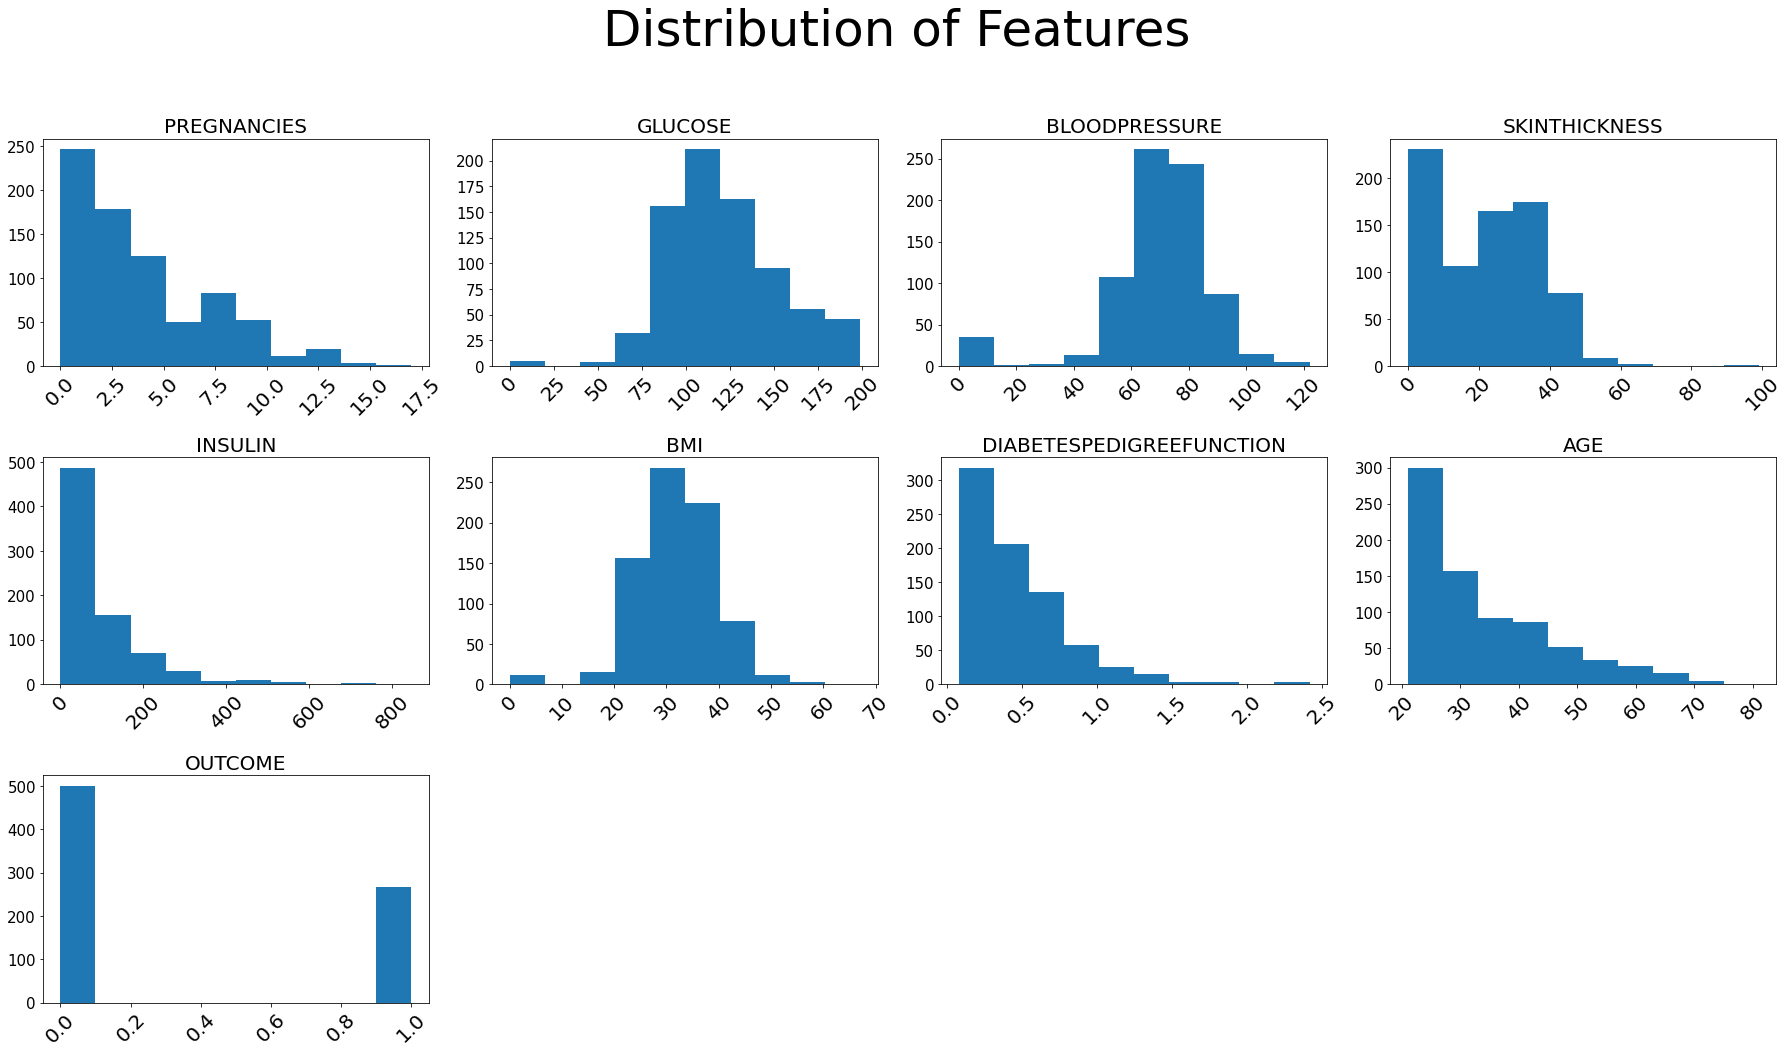

In [ ]:
#Distribucion de caracteristicas
fig = plt.figure(figsize=(25, 15))
st = fig.suptitle("Distribution of Features", fontsize=50, verticalalignment="center")
for col, num in zip(df.toPandas().describe().columns, range(1,11)):
  ax = fig.add_subplot(3,4, num)
  ax.hist(df.toPandas()[col])
  plt.grid(False)
  plt.xticks(rotation=45, fontsize=20)
  plt.yticks(fontsize=15)
  plt.title(col.upper(), fontsize=20)

plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85, hspace=0.4)
plt.show()

In [ ]:
col_names = numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])

In [ ]:
from pyspark.mllib.stat import Statistics
import pandas as pd

###e)**Reducción de dimensionalidad-Matriz de correlación**

Coeficiente de correlación Pearson: Número que denota la fuerza de la relación entre dos variables.

In [ ]:
#Matriz de correlacion con coeficiente de pearson
#Para poder hacer comparaciones se estandariza la covarianza, generando
corr_mat = Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index = col_names
corr_df.columns = col_names
round(corr_df, 2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.00,0.13,0.14,-0.08,-0.07,0.02,-0.03,0.54,0.22
Glucose,0.13,1.00,0.15,0.06,0.33,0.22,0.14,0.26,0.47
BloodPressure,0.14,0.15,1.00,0.21,0.09,0.28,0.04,0.24,0.07
SkinThickness,-0.08,0.06,0.21,1.00,0.44,0.39,0.18,-0.11,0.07
Insulin,-0.07,0.33,0.09,0.44,1.00,0.20,0.19,-0.04,0.13
BMI,0.02,0.22,0.28,0.39,0.20,1.00,0.14,0.04,0.29
DiabetesPedigreeFunction,-0.03,0.14,0.04,0.18,0.19,0.14,1.00,0.03,0.17
Age,0.54,0.26,0.24,-0.11,-0.04,0.04,0.03,1.00,0.24
Outcome,0.22,0.47,0.07,0.07,0.13,0.29,0.17,0.24,1.00


Gráfico: Para graficar la matriz, usaremos una biblioteca de visualización popular llamada seaborn.


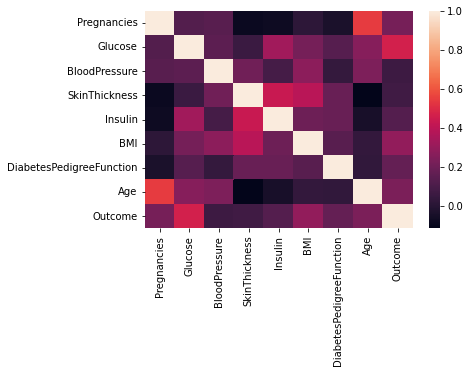

In [ ]:
#Mostrar mapa de calor que es una técnica de visualización de datos
sns.heatmap(corr_df);

Reducimos los atributos eligiendo los 5 valores con más correlación a la variable glucosa, variable escogida por ser uno de los indicadores de mayor trascendencia para determinar si una persona tiene diabetes.


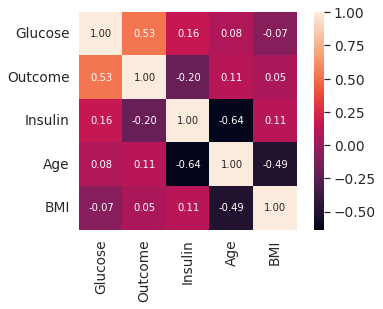

In [ ]:
#Variables variables con correlacion alta con Glucose
import numpy as np
k = 5
cols = corr_df.nlargest(k, 'Glucose')['Glucose'].index
cm = np.corrcoef(corr_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, 
fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, 
xticklabels=cols.values)
plt.show()

##**ALGORITMO NAIVE BAYES**


In [ ]:
# Importamos la libreria collections para mostrar lo que tienen los RDD's
import collections

# Leemos el dataset en forma de data frame
df_orig = spark.read.csv("diabetes.csv", header=True, inferSchema=True)
df_orig.show(5)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows



In [ ]:
'''
Creamos el RDD a partir del data frame
al mismo tiempo de damos un formato de: 
CLAVE-VALOR, donde:
  CLAVE: la columna de salida 'Outcome'
  VALOR: el resdo de columnas
''' 
rdd = df_orig.rdd.map(lambda x:  tuple(x))
rdd = rdd.map(lambda x: (x[8], (x[1], x[4], x[7], x[5])))

# extraemos el numero de datos
# y mostramos como queda el RDD
n = len(rdd.collect())
print("Total de datos: ", n)
print("RDD:")
rdd.collect()[:6]

Total de datos:  768
RDD:


[(1, (148, 0, 50, 33.6)),
 (0, (85, 0, 31, 26.6)),
 (1, (183, 0, 32, 23.3)),
 (0, (89, 94, 21, 28.1)),
 (1, (137, 168, 33, 43.1)),
 (0, (116, 0, 30, 25.6))]

###**Algoritmo Naive Bayes**
1. Convertir el conjunto de datos en una tabla de frecuencias. 
2. Crear una tabla de probabilidad calculando las correspondientes a que ocurran los diversos eventos. 
3. La ecuación Naive Bayes se usa para calcular la probabilidad posterior de cada clase.
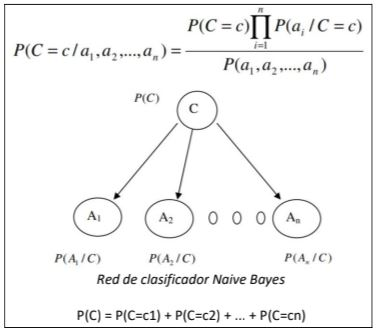

###**a. Cálculo de la frecuencia de la clase**

In [ ]:
# Colocamos un 1 a lado de cada clase y las sumamos
frec = rdd.mapValues(lambda x: 1).reduceByKey(lambda x, y: x + y).sortByKey()
frec.collect()[:10]

[(0, 500), (1, 268)]

In [ ]:
# Convertimos a lista para una mejor maniobrabilidad de datos
frecList = [i[1] for i in frec.collect()]
frecList

[500, 268]

###**b.Cálculo de probabilidad a posteriori (predicción de nuevos casos)**

    Utilizando tablas de probabilidad, media, desviación estándar**

In [ ]:
'''               MEDIA                   ...
Para hallar la Media seguimos dos pasos
1. Sumar los valores de cada columna agrupandas por clase
2. Divimos ese resultado por el nro total de datos
'''
sumTmp = rdd.reduceByKey(lambda x, y: (x[0]+y[0], x[1]+y[1], x[2]+y[2], x[3]+y[3]) )
means = sumTmp.mapValues(lambda x: (x[0]/n, x[1]/n, x[2]/n, x[3]/n)).sortByKey()
means.collect()[:10]

[(0, (71.6015625, 44.786458333333336, 20.305989583333332, 19.729296874999974)),
 (1,
  (49.29296875, 35.013020833333336, 12.934895833333334, 12.263281249999983))]

In [ ]:
# Convertimos a lista para una mejor maniobrabilidad de datos
meansList = [i[1] for i in means.collect()]
meansList

[(71.6015625, 44.786458333333336, 20.305989583333332, 19.729296874999974),
 (49.29296875, 35.013020833333336, 12.934895833333334, 12.263281249999983)]

In [ ]:
def squareDistanceToMean(x):
  label = 0 if x[0] == 0 else 1
  #mean = means.collect()[label]
  mean = meansList[label]
  col0 = abs(x[1][0] - mean[0])**2
  col1 = abs(x[1][1] - mean[1])**2
  col2 = abs(x[1][2] - mean[2])**2
  col3 = abs(x[1][2] - mean[3])**2
  return (label, (col0, col1, col2, col3))

In [ ]:
'''                  DESVIACION ESTANDAR               ...
Para hallar la desviacion estandar:
1. Calculamos el cuadrado de la distancia a la media de cada valor
2. Sumamos las distancias de cada columna agrupandolas por clase
3. Sacamos la raiz cuadrada de la suma de distancias sobre el nro total de datos
'''
distanceToMean = rdd.map(squareDistanceToMean)
sumDistances = distanceToMean.reduceByKey(lambda x, y: (x[0]+y[0], x[1]+y[1], x[2]+y[2], x[3]+y[3])).sortByKey()
devStdr = sumDistances.mapValues(lambda x: ((x[0]/n)**0.5, (x[1]/n)**0.5, (x[2]/n)**0.5, (x[3]/n)**0.5))
devStdr.collect()

[(0,
  (37.455703568075734,
   82.01190353891874,
   12.867604640579708,
   13.189563822497119)),
 (1,
  (57.49749426081236,
   90.42169765083963,
   15.653930703214288,
   16.016069814369644))]

In [ ]:
# Convertimos a lista para una mejor maniobrabilidad de datos
devStdrList = [i[1] for i in devStdr.collect()]
devStdrList

[(37.455703568075734,
  82.01190353891874,
  12.867604640579708,
  13.189563822497119),
 (57.49749426081236,
  90.42169765083963,
  15.653930703214288,
  16.016069814369644)]

##**PREDICCIÓN**


Cálculo de probabilidad a posteriori (predicción de nuevos casos)


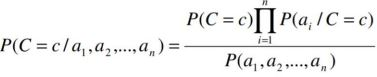

In [ ]:
from math import pi, exp, sqrt
'''
Encontramos la probabilidad de cada dato
usando la distribucion normal:

'''
def getProb(x, label, col):
  mean = meansList[label][col]
  dev = devStdrList[label][col]
  var = dev**2 
  factor1 = (1) / ((sqrt(2*pi)) * dev)
  factor2 = exp(-( ((x-mean)**2) / (2*var)))
  return factor1 * factor2

In [ ]:
'''
Calculamos una tabla que contenga
todas las probabilidad Apriori de cada dato

'''
def getProbsApriori(dat):
  # Encontramos las probabilidades de cada clase
  probClassTmp = [tuple(frecList)]
  probClass = list(map(lambda x: (x[0]/n, x[1]/n), probClassTmp))

  # Calculamos las probabilidades de los datos que queremos
  # predecir usando el modulo q evalua la distribucion normal
  probData = []
  for i in range(len(dat)):
    prob = (getProb(dat[i], 0, i), getProb(dat[i], 1, i))
    probData.append(prob)

  # unismo las dos tablas
  probApriori = probClass + probData
  return probApriori


In [ ]:
'''
En base a las probabilidades apriori 
calculamos la probabilidad a posteriori
para poder generar una prediccion
'''
def getProbPosteriori(probApriori):
  sc = spark.sparkContext
  predictRDD = sc.parallelize(probApriori)
  # Multiplicamos las probabilidades para cada clase
  f = predictRDD.reduce(lambda x, y: (x[0]*y[0], x[1]*y[1]))

  # calculamos la probabilidad a posteriori
  probPosteriori = tuple(map(lambda x: round((x/sum(f))*100, 2), f))
  return probPosteriori

##Finalmente para elegir la clase a la que pertenece, elegimos la probabilidad de mayor valor de la dos anteriores:

formato: 
> [ **glucosa**, **insulina**, **edad**, **Indice de masa corporal(IMC)**]

In [ ]:
datos1 = [100, 94, 40, 30]

In [ ]:
probApriori1 = getProbsApriori(datos1)
print('Tabla de propabilidades Apriori: ')
probApriori1

Tabla de propabilidades Apriori: 


[(0.6510416666666666, 0.3489583333333333),
 (0.007990343768683149, 0.0047030052021537),
 (0.004062934605564566, 0.0035663742098490238),
 (0.009610650436979567, 0.005716942093542189),
 (0.022336109009058976, 0.013490970627018258)]

Primera predicion

In [ ]:
datos1 = [100, 94, 40, 30]
predict1 = getProbPosteriori(probApriori1)
print('Tiene diabetes: ', datos1)
print('NO :', predict1[0], '%')
print('SI :', predict1[1], '%')

Tiene diabetes:  [100, 94, 40, 30]
NO : 90.95 %
SI : 9.05 %


Segundo predicion

In [ ]:
datos2 = [180, 86, 60, 25.5]
predict2 = getProbPosteriori(getProbsApriori(datos2))
print('Tiene diabetes: ', datos2)
print('NO :', predict2[0], '%')
print('SI :', predict2[1], '%')

Tiene diabetes:  [100, 94, 40, 30]
NO : 49.41 %
SI : 50.59 %


Tercera prediccion

In [ ]:
datos3 = [70, 0, 20, 23.3]
predict3 = getProbPosteriori(getProbsApriori(datos3))
print('Tiene diabetes: ', datos2)
print('NO :', predict3[0], '%')
print('SI :', predict3[1], '%')

Tiene diabetes:  [180, 86, 60, 25.5]
NO : 86.2 %
SI : 13.8 %


In [ ]:
datos4 = [200, 168, 20, 15]
predict4 = getProbPosteriori(getProbsApriori(datos4))
print('Tiene diabetes: ', datos2)
print('NO :', predict4[0], '%')
print('SI :', predict4[1], '%')

Tiene diabetes:  [180, 86, 60, 25.5]
NO : 28.99 %
SI : 71.01 %
